Pip install Required to install before running the code!!

In [1]:
#!pip install selenium
#!pip install pdfplumber
#!pip install pyperclip

Imports

In [2]:
import pdfplumber
import time
import csv
import os 
import pandas as pd
import traceback
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pyperclip
import xml.etree.ElementTree as ET
from scipy.stats import pearsonr
import requests
import matplotlib.pyplot as plt
import seaborn as sns



Helping Functions

In [3]:
#Function for couning the tables
def count_tables_in_pdf(pdf_path):
    target_table_header = ['Field', 'Description', 'Type', 'Default', 'Other']
    tables_with_target_header = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            tables = page.extract_tables()
            for table in tables:
                if table[0] == target_table_header:
                    tables_with_target_header.append(table)

    return len(tables_with_target_header), tables_with_target_header

#Function for couning the columns
def count_columns_in_pdf(pdf_path):
    total_rows = 0
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            tables = page.extract_tables()
            for table in tables:
                total_rows += len(table) 

    return total_rows

def delete_files_in_directory(directory):
# Get a list of files in the directory
    files = os.listdir(directory)

    # Delete each file in the directory
    for file in files:
        file_path = os.path.join(directory, file)
        try:
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        except OSError as e:
            print(f"Error deleting file: {file_path} - {e}")
            
#Function for updating the csv file. (still in progress)
def update_csv_with_diagram_size(repositories_file):
    temp_file = "temp_filtered_files.csv"

    with open(repositories_file, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        fieldnames = csv_reader.fieldnames
        if "diagram size" not in fieldnames:
            fieldnames.append("diagram size")

def convert_dbml_to_quickdiagram(input_text):
    # Split the input text into lines
    lines = input_text.split('\n')
    
    # Initialize the result string
    result = ''
    inside_table = False
    
    # Iterate through the lines and process each table definition
    for line in lines:
        line = line.strip()  # Remove leading and trailing whitespace
        if line.startswith('Table '):
            # Extract the table name
            table_name = line.split(' ')[1]
            result += f"{table_name}\n--\n"
            inside_table = True
        elif inside_table and (line.startswith('}') or line == ""):
            # End of the current table definition
            inside_table = False
            result += '\n'  # Add a line break after each table definition
        elif inside_table:
            # Extract the column name
            column_name = line.split(' ')[0]
            # Append the column name under the current table
            result += f"{column_name}\n"
    
    return result

def convert_xml_to_quickdiagram(xml_text):
    # Parse the XML
    root = ET.fromstring(xml_text)

    # Initialize the result string
    result = ''
    first_table = True  # Flag to check if it's the first table
    
    # Iterate through the "Table" elements
    for table_elem in root.findall('.//{http://schemas.microsoft.com/linqtosql/dbml/2007}Table'):
        table_name = table_elem.get('Name').replace('dbo.[', '').replace(']', '').replace('dbo.', '')  # Remove brackets and "dbo."
        table_name = table_name.replace(' ', '')  # Remove spaces
        # Add a newline character before each table (except the first one)
        if not first_table:
            result += '\n'
        first_table = False
        
        result += f"{table_name}\n--\n"

        # Iterate through the "Column" elements within the current table
        for column_elem in table_elem.findall('.//{http://schemas.microsoft.com/linqtosql/dbml/2007}Column'):
            column_name = column_elem.get('Name')  # Extract the column name
            result += f"{column_name}\n"

    return result

def is_xml_format(input_text):
    try:
        # Attempt to parse the input as XML
        root = ET.fromstring(input_text)
        # Check if the root element is the "Database" element
        return root.tag.endswith("Database")
    except ET.ParseError:
        # Parsing failed, indicating that the input is not in XML format
        return False


Functions to use for automation

In [4]:

def CopyContentFromGitHub(file_path):
    try:
        # Create a WebDriver instance for Firefox (you may need to specify the path to your Firefox driver)
        download_dir = "/PATH_TO_PROJECT_FILE/"
        firefox_options = webdriver.FirefoxOptions()
        firefox_options.set_preference("browser.download.folderList", 2)
        firefox_options.set_preference("browser.download.dir", download_dir)
        driver = webdriver.Firefox(options=firefox_options)

        # Navigate to the page where the target text area exists
        driver.get(file_path)
        initializeWait = WebDriverWait(driver, 15)

        # Find the text area by its id
        text_area = initializeWait.until(EC.presence_of_element_located((By.XPATH,"//*[@id='read-only-cursor-text-area']")))

        # Get the content of the text area
        content = text_area.get_attribute("value")
        time.sleep(1)

        # Close the browser
        driver.quit()
        return content

    except Exception as e:
        # Handle the exception (e.g., print an error message)
        print(f"An error occurred while using QuickDatabaseDiagram for file: {file_path}")
        print(f"Error message: {str(e)}")
            
        # Print the line of code that caused the exception
        traceback.print_exc()
        # Quit the browser and continue with the next file
        driver.quit()

def SeleniumPasteToQuickDatabaseDiagram(content):
    try:   
        download_dir = "PATH_TO_EXPORTED_PDF/ExportedPDF"
        firefox_options = webdriver.FirefoxOptions()
        firefox_options.set_preference("browser.download.folderList", 2)
        firefox_options.set_preference("browser.download.dir", download_dir)

        # Get a list of all SQL files in the SqlFiles folder

        driver = webdriver.Firefox(options=firefox_options)
        driver.get("https://app.quickdatabasediagrams.com/")
        driver.maximize_window()

        # Wait for the button to be present
        initializeWait = WebDriverWait(driver, 15)

        time.sleep(2)
        # Clicking on exit of getting started
        button = initializeWait.until(EC.presence_of_element_located((By.XPATH, "/html/body/div[5]/div/footer/ul/li[1]/a")))
        button.click()
        textField = initializeWait.until(EC.presence_of_element_located((By.XPATH,"/html/body/div[1]/main/div/div/dt-source-editor/div/div[1]/div[2]/textarea")))
        textField.clear()
        time.sleep(1)
        
        actions = ActionChains(driver)
        actions.send_keys(Keys.BACKSPACE)
        textField.send_keys(content)
        time.sleep(2)

        #Exporting button
        exportButton = initializeWait.until(EC.presence_of_element_located((By.XPATH, ("/html/body/header/dt-header/md-toolbar/div[3]/div/dt-source-editor-menu/md-menu-bar/md-menu[3]/button"))))
        exportButton.click()
        time.sleep(1)

        # Exporting as PDF button
        pdfDocumentationButton = initializeWait.until(EC.presence_of_element_located((By.XPATH, "//button[contains(text(), 'PDF Documentation')]")))
        # Click the button
        pdfDocumentationButton.click()

        time.sleep(5) 

        # Quit the browser before starting with the next file
        driver.quit()
 
    except Exception as e:
            # Handle the exception (e.g., print an error message)
            print(f"An error occurred while using QuickDatabaseDiagram for file")
            print(f"Error message: {str(e)}")
            
            # Print the line of code that caused the exception
            traceback.print_exc()
            # Quit the browser and continue with the next file
            driver.quit()
            



Proccess for converting syntax to QuickDatabaseDiagram and exporting result as PDF

In [ ]:
#csv file that has all the elements we need (Input)
repositories_file = "/Users/habeb/VscProjects/Selenium/filtered_files.csv"

#convering into df for handling
df = pd.read_csv(repositories_file)

df_test = df.head(5)

#looping over the df
for index, row in df_test.iterrows():
    #sql file URL
    file_url = row['File URL']
    print("*" *50)
    print(f"Working on File Number :{index}, {file_url}")
    print("*" *50)
    file_name = row['File']
    try:
        input = CopyContentFromGitHub(file_url)
        num_lines = input.count('\n') + 1
        if num_lines > 1000:
            raise Exception("DBML file is too big")
        if is_xml_format(input) :
            convertedInput = convert_xml_to_quickdiagram(input)
        else :
            convertedInput = convert_dbml_to_quickdiagram(input)
        if not bool(convertedInput):
           raise Exception("Converted content is empty")
        SeleniumPasteToQuickDatabaseDiagram(convertedInput)
           
    except Exception as e:
        print(f"Error message: {str(e)}")
        print("^" * 50) 
        continue

    pdf_folder = "/PATH_TO_EXPORTED_PDF/ExportedPDF"
    # Loop through each PDF file in the folder
    for filename in os.listdir(pdf_folder):
        if filename.endswith(".pdf"):
            pdf_file_path = os.path.join(pdf_folder, filename)

            # Count tables and print the output
            table_count, target_tables = count_tables_in_pdf(pdf_file_path)
            print(f"File: {file_url}")
            print(f"Number of tables in the PDF: {table_count}")

            # Count columns and print the output
            column_count = count_columns_in_pdf(pdf_file_path)
            column_size = (column_count - table_count) * 2 + 1
            print(f"Total number of columns in the PDF: {column_size}")

            #Count total size
            totalSize = column_size + table_count
            print(f"Total size of diagram: {totalSize}")
            print("-" * 50) 

            df_test.loc[index, "diagram size"] = totalSize
            df_test.loc[index, "table count"] = table_count
            df_test.loc[index, "column count"] = column_size

    pdf_files_directory = '/PATH_TO_EXPORTED_PDF/ExportedPDF'

    # Call the function to delete files in each directory
    delete_files_in_directory(pdf_files_directory)
    
print(df_test.head())




In [6]:
df_testing = df_test

In [7]:
df_testing

,Repository,Repository URL,File,File URL,Primary Language,diagram size,table count,column count
0,simplebank,https://github.com/techschool/simplebank,db.dbml,https://github.com/techschool/simplebank/blob/...,Go,39.0,6.0,33.0
1,vaahcms,https://github.com/webreinvent/vaahcms,vaahcms.dbml,https://github.com/webreinvent/vaahcms/blob/a8...,JavaScript,129.0,12.0,117.0
2,Samples,https://github.com/Code-Inside/Samples,DataClassesNoGuid.dbml,https://github.com/Code-Inside/Samples/blob/e1...,JavaScript,7.0,2.0,5.0
3,spark,https://github.com/SparkViewEngine/spark,Northwind.dbml,https://github.com/SparkViewEngine/spark/blob/...,C#,29.0,4.0,25.0
4,protobuf-net,https://github.com/protobuf-net/protobuf-net,NWind.dbml,https://github.com/protobuf-net/protobuf-net/b...,C#,21.0,2.0,19.0


Dropping nulls

In [8]:
df_testing.dropna()

,Repository,Repository URL,File,File URL,Primary Language,diagram size,table count,column count
0,simplebank,https://github.com/techschool/simplebank,db.dbml,https://github.com/techschool/simplebank/blob/...,Go,39.0,6.0,33.0
1,vaahcms,https://github.com/webreinvent/vaahcms,vaahcms.dbml,https://github.com/webreinvent/vaahcms/blob/a8...,JavaScript,129.0,12.0,117.0
2,Samples,https://github.com/Code-Inside/Samples,DataClassesNoGuid.dbml,https://github.com/Code-Inside/Samples/blob/e1...,JavaScript,7.0,2.0,5.0
3,spark,https://github.com/SparkViewEngine/spark,Northwind.dbml,https://github.com/SparkViewEngine/spark/blob/...,C#,29.0,4.0,25.0
4,protobuf-net,https://github.com/protobuf-net/protobuf-net,NWind.dbml,https://github.com/protobuf-net/protobuf-net/b...,C#,21.0,2.0,19.0


Save dataframe into CSV file

In [9]:

csv_filename = "initial_output.csv"

# Save the DataFrame to the CSV file
df_testing.to_csv(csv_filename, index=False)  # Set index=False to exclude the index column from the CSV

print(f"DataFrame has been saved to {csv_filename}.")

print(df_testing.head())

DataFrame has been saved to initial_output.csv.
     Repository                                Repository URL  \
0    simplebank      https://github.com/techschool/simplebank   
1       vaahcms        https://github.com/webreinvent/vaahcms   
2       Samples        https://github.com/Code-Inside/Samples   
3         spark      https://github.com/SparkViewEngine/spark   
4  protobuf-net  https://github.com/protobuf-net/protobuf-net   

                     File                                           File URL  \
0                 db.dbml  https://github.com/techschool/simplebank/blob/...   
1            vaahcms.dbml  https://github.com/webreinvent/vaahcms/blob/a8...   
2  DataClassesNoGuid.dbml  https://github.com/Code-Inside/Samples/blob/e1...   
3          Northwind.dbml  https://github.com/SparkViewEngine/spark/blob/...   
4              NWind.dbml  https://github.com/protobuf-net/protobuf-net/b...   

  Primary Language  diagram size  table count  column count  
0               Go

Visualizing the distribution of diagream size by primary coding language

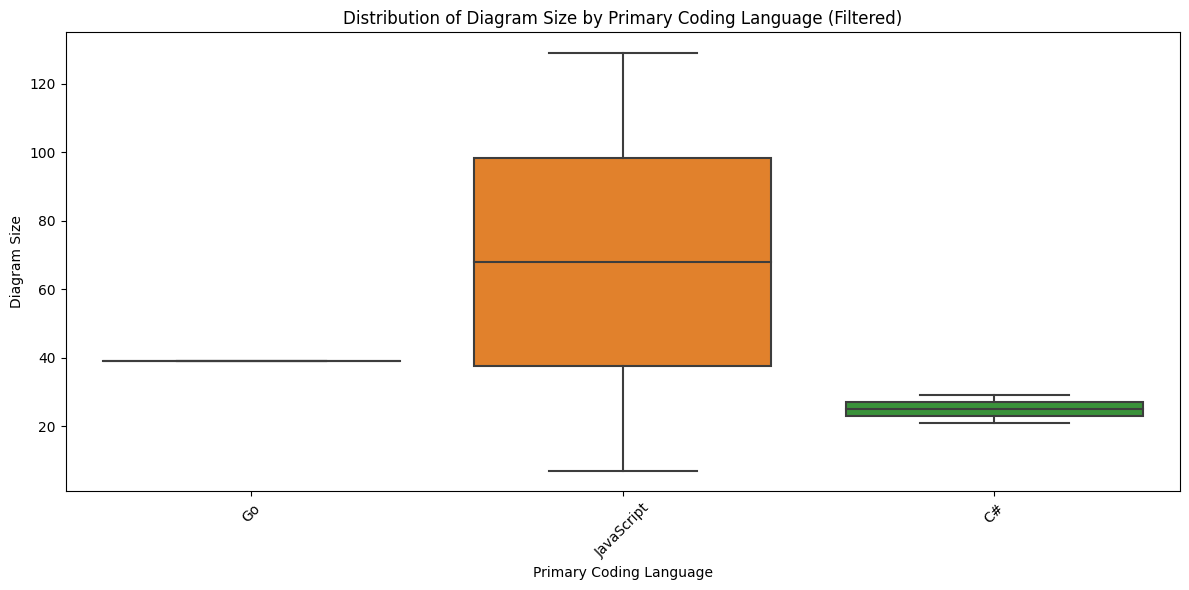

In [10]:
min_data_points = 1
# Count the occurrences of each primary coding language
language_counts = df_testing['Primary Language'].value_counts()

# Filter out languages with fewer data points than the threshold
filtered_languages = language_counts[language_counts >= min_data_points].index

# Create a new DataFrame with filtered languages
filtered_df = df_testing[df_testing['Primary Language'].isin(filtered_languages)]

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Primary Language', y='diagram size', data=filtered_df)
plt.title("Distribution of Diagram Size by Primary Coding Language (Filtered)")
plt.xlabel("Primary Coding Language")
plt.ylabel("Diagram Size")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

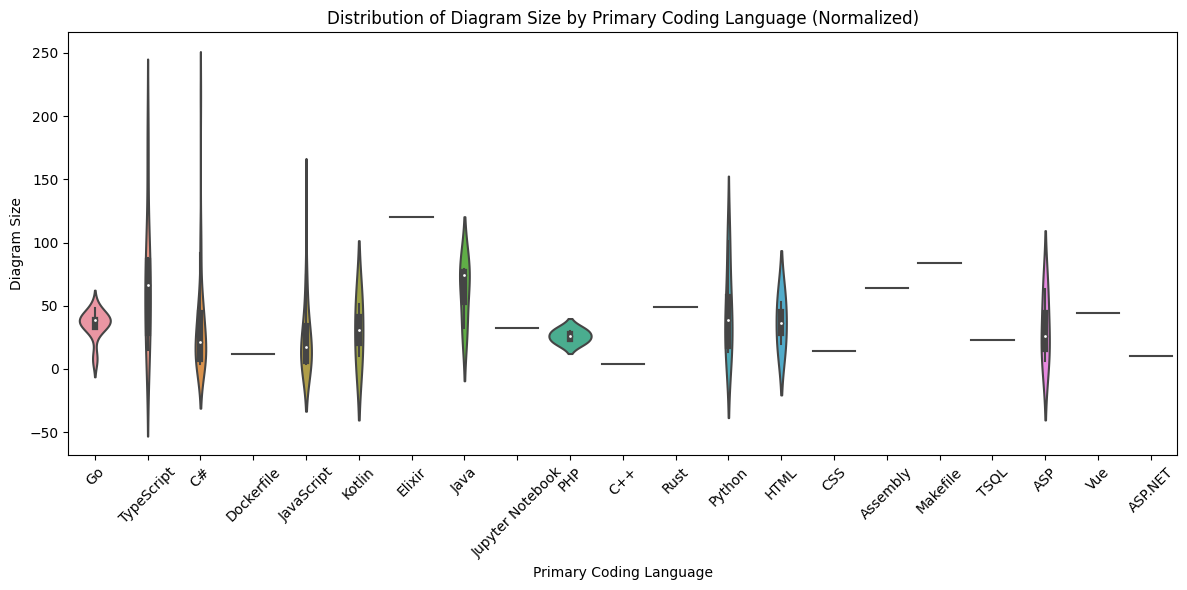

In [11]:

output_file = "/PATH_TO_OUTPUT_FILE/output copy 2.csv"
df_testing = pd.read_csv(output_file)

#Minimum number of data pointsd
min_data_points = 1

# Count the occurrences of each primary coding language
language_counts = df_testing['Primary Language'].value_counts()

# Filter out languages with fewer data points than the threshold
filtered_languages = language_counts[language_counts >= min_data_points].index

# Create a new DataFrame with filtered languages
filtered_df = df_testing[df_testing['Primary Language'].isin(filtered_languages)]

# Create a normalized violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Primary Language', y='diagram size', data=filtered_df)
plt.title("Distribution of Diagram Size by Primary Coding Language (Normalized)")
plt.xlabel("Primary Coding Language")
plt.ylabel("Diagram Size")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
